# Regression Algorithms


## Linear regression
*Refs : [1]*

A linear regression model can be expressed as: 
$$ y = \theta_0 + \theta_1*x_1 + \theta_2*x_2 ... \theta_n*x_n$$
where $y$ is the predicted value (the label), $x_i$ is the $i$th feature and $\theta_j$ is the $j$th model parameter. $\theta_0$ is called the biais term and $\theta_i$ feature weights. The model can be expressed in a vectorisze form: 
$$ y = h_\theta(X) = \theta . X$$
where $\theta$ is the model parameters vector containing the biais term and feature wieghts, $X$ the features vector containing $x_0$ to $x_n$ with $x_0 = 1$. $h_\theta(X)$ is the hypothesis function using model parameter $\theta$. 
> $X$ and $\theta$ are generally expressed as column vectors. To calculate $y$ the dot product should be calculated using the transposed of $\theta$: $y = \theta^T.X$

Training a linear regression model means to find a $\theta$ vector so that it best fits the training dataset. Model fitting is assessed using a performance measure (e.g. RMSE, cf. performance-measures.md) that should be maximazed (if it is a utility function) or minimized (if it is a cost function) during model training. 

### Closed-form equations

One of the most used cost function to measure a linear regression model performance is the RMSE (root mean square error). Minimizing the RMSE is equivalent to minimize MSE (is it is its squared value):  
$$ MSE(X, h_\theta) = \frac{1}{m} \sum_{i = 1}^{m} (\theta^T.x^{(i)} - y^{(i)})^2 $$  

To find the value of $\theta$ that minimazes the MSE, we can use the *closed-form* solution, called **the normal equation**:
$$ \hat{\theta} = (X^TX)^{-1} X^T y $$
where $\hat{\theta}$ is the $\theta$ that minimizes the MSE and $y$ the vector of target values (labels) in the training set.

**Example**: Computing $\hat{\theta}$ for a toy example using the normal function and comparing it to $\theta$ given by implementation in Scikit-learn     

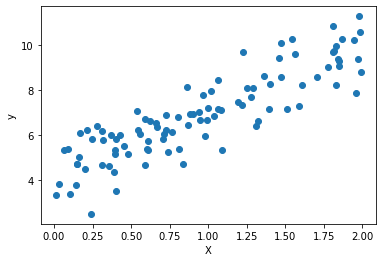

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1) #random for gaussian noise
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

[[4.22840236]
 [2.83590825]]


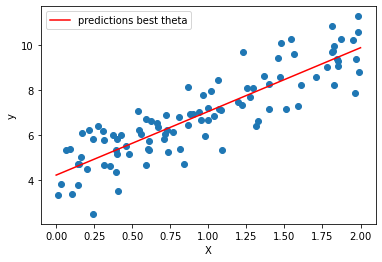

In [2]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print(theta_best)

# predictions using theta best
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new] # adding x0 = 1 to each value
y_predict = X_new_b.dot(theta_best)
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.plot(X_new, y_predict, "r-", label="predictions best theta")
plt.legend()
plt.show()


[4.22840236] [[2.83590825]]


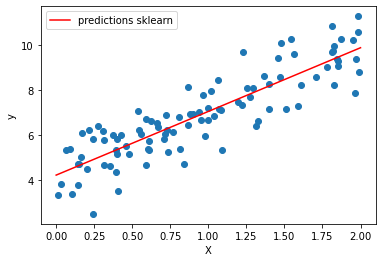

In [3]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)
y_predict = lin_reg.predict(X_new)
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.plot(X_new, y_predict, "r-", label="predictions sklearn")
plt.legend()
plt.show()


Sklearn computes $\hat{\theta}$ using a different appraoch using the Moore-Penrose inverse or *pseudoinverse*, and SVD (see [3] for details). This appraoch permits to handle cases where $X^TX$ is not invertible, making it impossible de use the normal equation. 

In terms of complexity, the normal equation and the SVD approach have quadratic to cubic time complexity w.r.t. number of features (with slight advantage for the SVD appraoch) and is linear w.r.t. number of samples. Thus, this approach runs fast given enough memory. 

### Gradient descent

Gardient descent is an optimization iterative algorithm devised to find local minimums (e.g. minimizing a cost function). It consists in taking small steps, given a learning rate, in the inverse direction of the gradient until reaching a local minimum. This approach, at least for its simplest version, does not garantee to reach the global as it can be "stuck" in local minimas or in plateaus.  

Gradient descent case be used to find $\hat{\theta}$ as it is the value of $\theta$ that minimizes the quadratic cost function. As this latter is convex (as it is quadratic) and continuous, there is only one global minimum wich  garantees to approach the optimal solution.

> Always ensure that all variables have similar scales when using gradient descent (e.g. sklearn StandardScaler) for fast convergence. 

Gradient descent algorithm can also be used to reach local maximums. In this case, it is called *gradient ascent*. Local maximum are reached by directing the search towards the same direction as positive gradient. 

#### Batch gradient descent 

The basic idea of gradient is to explore the parameters space using steps directed torwards the opposite direction of the gradient. In other terms, if the slope is positive, the algorithm increments a parameter in the direction (adding or substracting an increment) such that the value of the target cost function is smaller. In terms of implementation, a gradient descent exploration is done using partial derivatives of the cost function w.r.t. each parameter. For instance, the partial derivative of the MSE w.r.t. $\theta_j$ is written: 
$$ \frac{\partial}{\partial \theta_j}MSE(\theta) = \frac{2}{m} \sum_{i = 1}^m (\theta^T x^{(i)} - y^{(i)} ) x_j^{(i)}  $$ 
For each reached temporary $\theta$, the algorithm computes partial derivatives w.r.t. all parameters in $\theta$ to determine the next $\theta$ to be explored. These values constitute the gradient vector 
$$\nabla_\theta MSE(\theta) = \frac{2}{m} X^T(X \theta - y)$$

Using this approach, notice that for each iteration of the algorithm, all samples in the dataset are used to compute the gradient vector which can slow down the exploration process.

One the gradient vector is computed, the algorithm computes $\theta$ for the next iteration: 
$$ \theta_{next} = \theta - \eta \nabla_\theta MSE(\theta) $$
where $\eta$ is the learning rate (algorithm hyperparameter) that determines the size of the downhill step. (Learning rate can be determined using gridsearh)

The algorithm stops when it reaches the user-given iterations limit. In order to interupt iteration process when the vector gradient becomes enough small (the gain in solution becomes negligible), the user can set a tolerent parameter $\epsilon$ to which the norm of the gradient vector is compared. If the norm of the gradient is smaller than $\epsilon$, then $\hat{\theta}$ is almost reached and iteration can stop.   

Implementation in the next cell. 

You can play with the gradient_descent parameters in line to display temporary theta. You can notice that if the tolerence threshold is not reached, the algorithm probably needs more iterations or lowering the learning rate.  

break at iteration  2746
[[4.22817576]
 [2.8361079 ]]


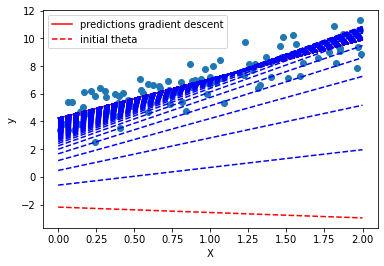

In [4]:

def gradient_descent(X, y, eta, epsilon, n_iterations, temporary_theta_each_n = 20):
    temporary_thetas = []
    X_b = np.c_[np.ones((X.size, 1)), X]
    theta = np.random.randn(2,1)
    for iteration in range(n_iterations):
        gradients = 2/X.size * X_b.T.dot(X_b.dot(theta) - y)
        if np.linalg.norm(gradients) < epsilon:
            print("break at iteration ", iteration)
            break
        theta = theta - eta*gradients
        if iteration % temporary_theta_each_n == 0:
            temporary_thetas.append((iteration, X_new_b.dot(theta)))
    return theta, temporary_thetas

theta_final, temporary_thetas = gradient_descent(X, y, 0.01, 0.0001, 100000, 10)
print(theta_final)
y_predict = X_new_b.dot(theta_final)
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.plot(X_new, y_predict, "r-", label="predictions gradient descent")
plt.plot(X_new, temporary_thetas[0][1], "r--", label="initial theta")
for temp in temporary_thetas[1:]:
    plt.plot(X_new, temp[1], "b--")
plt.legend()
plt.show()

#### Stochastic gradient descent

There is two main limitations with batch gradient descent approach: 
* It can the global minimum if the cost function contain multiple local minima 
* It uses all samples to compute the gradient vector which can be time consuming for large datasets. 

The gradient descent approach can be executed by picking a random sample to compute the gradient vector. This method is called stochastic gradient descent. This has two advantages: making the algorithm much faster and randomness in sample picking for gradient computation may permit to escape local minimum and thus has more chances to reach the global minima. 

The drawback if this method is derived also from the its stochastic nature: stochastic gradient descent is less regular since there is no garantee to decrease toward the optimal solution at each iteration but decreases in avergage. When reaching the area of the minimum, it will keep bouncing arround it without ever settling down. So, when the algorithm stops, it will provide a good solution but not the solution that approaches the best the optimal solution.

One way to tackle this convergence issue is to use a decreasing learning rate: when the algorithms decreases enough towards the minimum, it can reduce gradually its learning rate until settling in a small range that is tighly close to the optimal solution. This appraoch is called **Simulated Annealing** (cf. metaheuristics). It uses a learning schedule function to determine the learning rate at each iteration.  

[[4.22038126]
 [2.82403335]]


/opt/anaconda3/envs/handson/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


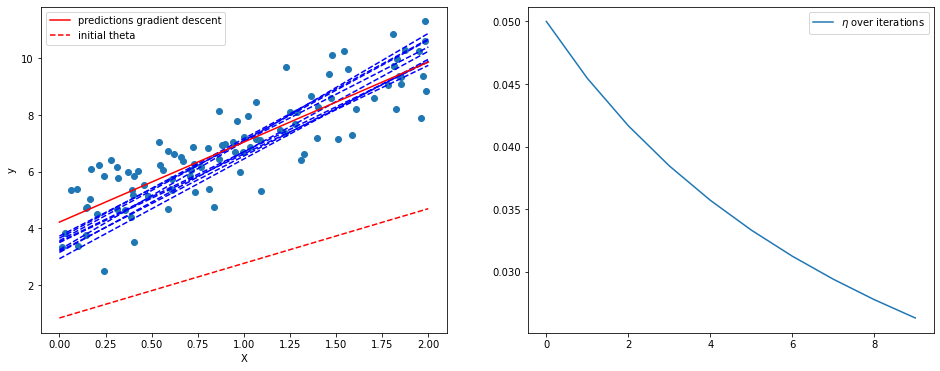

In [5]:
def learning_schedule(t, t0 = 5, t1=100):
    return t0/(t + t1)

def stochastic_gradient_descent(X, y, n_epochs, temporary_theta_each_n = 10):
    theta = np.random.randn(2,1)
    temp_thetas = []
    temp_etas = []
    for epoch in range(n_epochs):
        for i in range(X.size): 
            random_index = np.random.randint(X.size)
            x_i = X_b[random_index:random_index + 1]
            y_i = y[random_index:random_index + 1] 
            gradients = 2 * x_i.T.dot(x_i.dot(theta) - y_i)
            eta = learning_schedule(epoch*X.size + i)
            theta = theta - eta*gradients
            if epoch*X.size + i % temporary_theta_each_n == 0:
                temp_thetas.append((epoch*X.size + i, X_new_b.dot(theta)))
                temp_etas.append(eta)

    return theta, temp_thetas, temp_etas

theta_final, temporary_thetas, temp_etas = stochastic_gradient_descent(X, y, 1000)
print(theta_final)
y_predict = X_new_b.dot(theta_final)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.scatter(X, y)
ax1.set(xlabel ="X" , ylabel = "y" )
for temp in temporary_thetas[1:]:
    ax1.plot(X_new, temp[1], "b--")
ax1.plot(X_new, y_predict, "r-", label="predictions gradient descent")
ax1.plot(X_new, temporary_thetas[0][1], "r--", label="initial theta")
ax1.legend()
ax2.plot(range(len(temp_etas)), temp_etas, label="$\eta$ over iterations")
ax2.legend()

fig.show()


#### Mini-batch gradient descent

Mini-batch gradient descent lies between batch gradient descent and stochastic gradient descent. A each iteration it uses a mini-batch, i.e. a randomly picked sample of the dataset, to compute the gradient vector instead of all samples (batch-based) or single randomly chosen sample. 


Implementation of Linear regression in sklearn: 
* Closed-form equation using pseudoinverse : sklearn.linear_model.LinearRegression
* Batch GD, stochastic GD and, Mini-batch GD : sklearn.linear_model.SGDRegressor

## Polynomial regression

Let us first consider the case where $X$ is uni-dimmensional (i.e. $X$ contains 1 feature). A polynomial model of order $n$ is expressed as the sum of weighted powers of $X$ :
$$ \hat{y} = \theta_0 + \theta_1*X  + \theta_2*X^2 ... \theta_n*x^n + \epsilon $$
where $\epsilon$ is an error term. Training a polynomial regression model consists of finding a parameter vector $\theta = \begin{pmatrix} \theta_0 \\ \theta_1 \\ ... \\ \theta_n \end {pmatrix} $  miniminzing a cost function. One can remark that this problem is equivalent to a linear regression problem as treated higher considering powers of X (or more precisely its unique feature) as a set of $n$ features. Polynomial regression can then be considered as a special case of multiple linear regression (i.e. linear regression considering more than one variable).

Let us consider the following example:

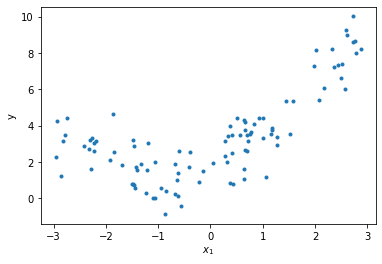

In [6]:
m = 100
X = 6* np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.scatter(X, y, marker=".")
plt.xlabel("$x_1$")
plt.ylabel("y")
plt.show()

In [7]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print("x :", X[0])
print("x^2", X[0]*X[0])
print("poly features result", X_poly[0])

x : [2.17959726]
x^2 [4.7506442]
poly features result [2.17959726 4.7506442 ]


*PolynomialFeatures* transforms the dataset by adding powers of the feature until the specified degree (here 2). 
Provided this transofmed dataset, we can apply a linear regression as if powers of features of X where plain features. 

In [8]:
linear_reg = LinearRegression()
linear_reg.fit(X_poly, y)
linear_reg.intercept_, linear_reg.coef_

(array([1.93425066]), array([[1.00101203, 0.53303649]]))

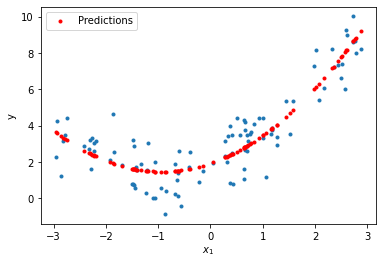

In [9]:
y_predicted = linear_reg.intercept_[0] + linear_reg.coef_[0][0] * X + linear_reg.coef_[0][1] * X**2


plt.scatter(X, y, marker=".")
plt.scatter(X, y_predicted, marker=".", color="red", label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("y")
plt.legend()
plt.show()

which is not that bad. 

In the case where $X$ has multiple features, the same approach is used by augmenting the dataset by powers of the feature and combinations of features up the the given degree. For example, if $X = (x_1, x_2, x_3)$ and a polynomial degree $3$, the transformed datasets will contain powers of the features : $x_1, x_1^2, x_2, x_2^2 ...$ and combination of features: $x_1x_2, x_1^2x_2 ...$.

Notice that this approach considers datasets with potentially a really high number of features for linear regression which could affect perfomances.

## Polynomial degrees, underfitting and overfitting

For our example, we could have chosen a differnt polynomial degree. Let's test polynomial regression on the same dataset with degrees 1 and 50. 


In [10]:
poly1 = LinearRegression()
poly1.fit(X, y)


features_50 = PolynomialFeatures(degree=50, include_bias=False)
X_50 = features_50.fit_transform(X)
poly50 = LinearRegression()
poly50.fit(X_50, y)

LinearRegression()

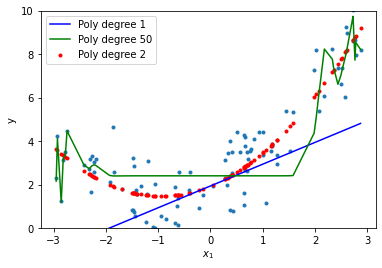

In [11]:
X_plot = np.copy(X)
X_plot = np.sort(X_plot, axis=0)

y_predicted_poly1 = linear_reg.intercept_[0] + linear_reg.coef_[0][0] * X_plot 

y_predicted_poly50 = []
for x in X_plot:
    pred = poly50.intercept_[0]
    for i in range(len(poly50.coef_[0])):
        pred += poly50.coef_[0][i] * x**(i+1)
        
    y_predicted_poly50.append(pred)

plt.scatter(X, y, marker=".", linewidths=1)
plt.scatter(X, y_predicted, marker=".", color="red", label="Poly degree 2")
plt.plot(X_plot, y_predicted_poly1, "b-", label="Poly degree 1")
plt.plot(X_plot, y_predicted_poly50, "g-", label="Poly degree 50")
plt.xlabel("$x_1$")
plt.ylabel("y")
plt.ylim(0, 10)
plt.legend()
plt.show()   


The high degree polynomial regression model is overfitting: it performs quite well on the training set (it tries to include most of training data points into the model) while the linear model is underfitting since it performs 

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.1)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-", linewidth=1, label="training error")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=1 ,label="validation error")
    plt.ylim(0, 5)
    plt.legend()     

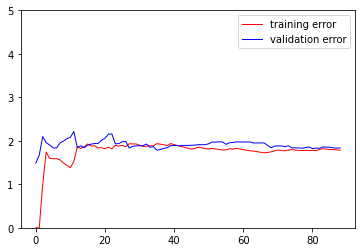

In [13]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X,y)

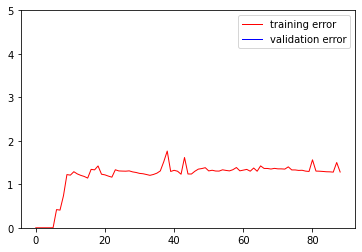

In [14]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=50, include_bias=False)),
    ("line_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

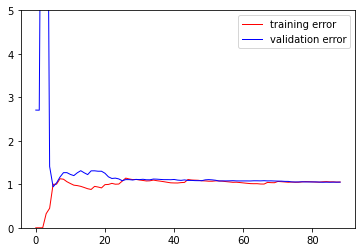

In [15]:
quadratic_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("line_reg", LinearRegression())
])

plot_learning_curves(quadratic_regression, X, y)